# 07. 예측모델 실습

예측 모델의 정확도를 높이기 위해 어떠한 방법을 사용하는지 확인해봅니다.

* **분석데이터**:
  https://www.kaggle.com/c/bike-sharing-demand
  
* **랜덤 시드**:
  https://namu.wiki/w/%EC%8B%9C%EB%93%9C#s-3
  
* **random_state = 42**:
  https://ichi.pro/ko/random-state-42neun-mueos-ibnikka-237508473317227
  
* **머신러닝 배우지 마세요**:
  https://www.youtube.com/watch?v=432p379XXMw
  
  

## grid_search_workflow

![Grid Search Workflow](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

In [1]:
from sklearn.model_selection import GridSearchCV

dtree = DecisionTreeClassifier()
dtree.fit(x, y)

# parameter를 dictionary 형태로 설정
parameters = {'max_depth':[1,2,3], 'min_samples_split':[2,3]}

# param_grid: 하이퍼파라미터
# cv: 3개의 train, test set fold 로 나누어 학습    
grid_dtree = GridSearchCV(dtree, param_grid=parameters, cv=3)

# param_grid의 하이퍼파라미터들을 순차적으로 학습
grid_dtree.fit(X_train, y_train)

# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_dtree.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 'split1_test_score', 'split2_test_score']]


# 최고 성능을 낸 분류기
estimator = grid_dtree.best_estimator_
pred = estimator.predict(X_test)
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))

NameError: name 'DecisionTreeClassifier' is not defined

![../_images/grid_search_cross_validation.png](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

## Step1. LinearRegressor를 사용하여 분류기 만들기

### 데이터 클렌징 및 가공

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./dataset/bike_sharing_demand_train.csv')
bike_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Data Fields**

- datetime - 대여날짜 및 시간 
- season - 계절 (1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울 ) 
- holiday - 휴일 
- workingday - 주말과 휴일을 제외한 날 (평일) 
- weather - 날씨 * 1: 맑음, 대체로 흐림, 일부 흐림 * 2: 안개 + 흐림, 안개 + 깨진 구름, 안개 + 구름이 거의 없음, 안개 * 3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름 * 4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개 
- temp - 섭씨 온도 
- atemp - 체감 온도 
- humidity - 상대 습도 
- windspeed - 풍속 
- casual - 미등록 사용자의 대여 횟수 
- registered - 등록된 사용자의 대여 횟수 
- count - 총 대여수

### [Q1] 분석할 데이터는 몇 개의 feature, 몇 개의 데이터로 구성되어 있습니까?

In [6]:
bike_df.shape
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### [Q2] bike_df의 데이터 중 숫자가 아닌 데이터가 포함된 필드가 있습니까?

In [7]:
bike_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### [Q3]'datetime'에 있는 값을 'year', 'month', 'day', 'hour' 필드에 파싱하여 넣어주세요.
예)
2011-01-01 00:00:00 -> 2011	1	1	0

(힌트)
python의 'datetime64' 포맷을 활용해보세요

In [8]:
bike_df['datetime'] = bike_df['datetime'].astype('datetime64')

bike_df['year'] = bike_df['datetime'].dt.year
bike_df['month'] = bike_df['datetime'].dt.month 
bike_df['day'] = bike_df['datetime'].dt.day
bike_df['hour'] = bike_df['datetime'].dt.hour
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


### [Q4] 각 데이터 필드의 값을 확인하시고, 불필요한 필드는 제거해주세요

In [9]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


### [Q5] 모델을 만들기 위해 train set과 test set으로 분리해주세요.
 1) 종속변수y 에 해당하는 값을 Y로 할당    
 2) 독립변수x 에 해당하는 값을 X로 할당  
 3) train_test_split 함수를 사용해서 분리(train:test = 7:3, random_state=0)

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression#, Ridge, Lasso

Y = bike_df['count']
X = bike_df.drop(['count'], axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

### [Q6] LinearRegression을 사용하여 예측하는 모델을 학습시킵니다.

In [11]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

### [Q7] 모델을 사용하여 테스트 셋으로 분리한 값(X_test)의 예측값을 구합니다.

In [12]:
pred = lr_model.predict(X_test)

### [Q8] 모델의 정확도를 측정합니다. 
이 대회에서 정확도 평가는 RMSLE(Root Mean Squared Log Error)입니다. RMSLE는 아래 함수를 사용하세요

In [13]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    print('RMSLE: {0:.4f}'.format(rmsle))
    return rmsle

In [14]:
rmsle(y_test ,pred)

RMSLE: 1.1647


1.1646636237111787

## Step2. 모델 성능 개선하기

### 예측값과 실제값의 차이가 가장 많이 나는 데이터 5개 출력

In [15]:
def get_top5_error_data(y_test, pred):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    # 예측값(pred)을 'predicted_count' 컬럼에 넣기
    result_df['predicted_count']= np.round(pred)
    # 실제값과 예측값과의 차이를 'diff' 컬럼에 넣기
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:5])
    
get_top5_error_data(y_test,pred)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


### [Q1] Y값 분포 시각화하기

(힌트) 히스토그램을 그려보세요.

<AxesSubplot:>

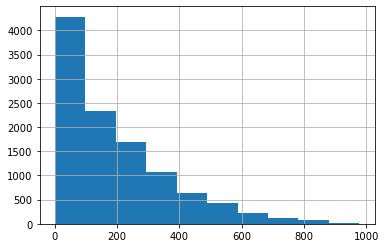

In [16]:
Y.hist()

### [Q2] Y의 로그값 분포 시각화하기

(힌트) 히스토그램을 그려보세요.  
(힌트) 로그변환: numpy의 log1p() 함수


<AxesSubplot:>

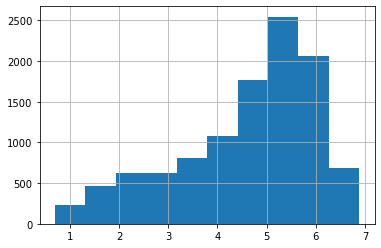

In [17]:
y_log = np.log1p(Y)
y_log.hist()

### [Q3] Y의 로그값을 사용하여 모델 만들어보기

In [18]:
# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=0)

In [19]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        # 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
        y_test = np.expm1(y_test)
        # 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    rmsle(y_test, pred)

In [20]:
lr_model_with_log = LinearRegression()
get_model_predict(lr_model_with_log, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 1.0168


### 선형회귀모델에서 가장 영향을 많으 주는 종속변수 알아보기

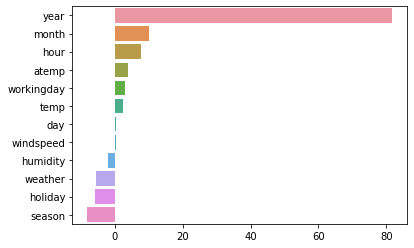

In [21]:
def plotFeatureList(model, X):
    coef = pd.Series(model.coef_, index=X.columns)
    coef_sort = coef.sort_values(ascending=False)
    sns.barplot(x=coef_sort.values, y=coef_sort.index)

plotFeatureList(lr_model, X)

### [Q4] 수치형 데이터 중 카테고리형 데이터 One Hot Encoding 하기

In [22]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

### [Q5] One Hot Encoding 적용된 feature 데이터 세트 기반으로 학습/예측 

 * 데이터 분할
 * 학습
 * 예측
 * 평가
 
### [Q6] 다양한 회귀모델을 사용하여 모델링하기

* RandomForestRegressor
* GradientBoostingRegressor
* XGBRegressor
* LGBMRegressor

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_log, test_size=0.3, random_state=0)

# LinearRegression, 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=500)
gbm_model = GradientBoostingRegressor(n_estimators=500)
xgb_model = XGBRegressor(n_estimators=500)
lgbm_model = LGBMRegressor(n_estimators=500)

model_list = [lr_model, rf_model, gbm_model, xgb_model, lgbm_model]
for model in model_list:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.5896
### RandomForestRegressor ###
RMSLE: 0.3532
### GradientBoostingRegressor ###
RMSLE: 0.3298
### XGBRegressor ###
RMSLE: 0.3422
### LGBMRegressor ###
RMSLE: 0.3188
